# Notebook to Analyze Text File Output of CAEN Wavedump

- requirements python 3.9, numpy, matplotlib, scipy
- to install missing packages do: `!{sys.executable} -m pip install <moduleName>`

In [1]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy

In [2]:
## -------------------------------- ##
##        SET PLOTTING STYLE        ##
## -------------------------------- ##
matplotlib.rcParams['figure.figsize'] = 8.5,6
matplotlib.rcParams['figure.subplot.left'] = 0.15
matplotlib.rcParams['figure.subplot.right'] = 0.88
matplotlib.rcParams['figure.subplot.bottom'] = 0.15
matplotlib.rcParams['figure.subplot.top'] = 0.88
matplotlib.rcParams['axes.titlesize'] = 20
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.labelweight'] = 'normal'
matplotlib.rcParams['font.weight'] = 'normal' 
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 10
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['ytick.major.size'] = 8
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['ytick.minor.size'] = 4
matplotlib.rcParams['xtick.minor.visible'] = True 
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['xtick.direction'] = 'in' 
matplotlib.rcParams['ytick.direction'] = 'in' 
matplotlib.rcParams['xtick.top'] = True 
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['xtick.major.pad'] = 6
matplotlib.rcParams['image.cmap'] = 'viridis'

CAEN will output a text file for each channel for which a signal is digitized
- In this case just channel 0
- Events are written out continously
- Window lengths can be 1024, 540, 256, or 136 samples
- Each sample is 2 ns
- Output is a single column of ADC units (2 Vpp --> 14 bit)
- no demarcation of new event ==> need to know window length in samples

In [17]:

## ------------------------------------------------ ##
##               USER DEFINED INPUTS                ##
## ------------------------------------------------ ##

## File to analyze
#inputFile = '/Users/danielkodroff/Desktop/HydroX/Data/RawPMTWaveforms/wave0.txt'
#inputFile = '/Users/danielkodroff/Desktop/HydroX/Data/RawPMTWaveforms/wave0_b.dat'
inputFile = '/Users/danielkodroff/Desktop/HydroX/Data/RawPMTWaveforms/wave0.dat'

## Window length in samples
windowLength = 520.

## binary or ASCII
fileType = "binary"

## ------------------------------------------ ##
##       GET EACH WAVEFORM FROM FILE          ##
## ------------------------------------------ ##

## Get the data depending on filetype
ch0data = None
if fileType == "binary":
    print('Opening binary file!')
    with open(inputFile, 'rb') as inFile:
        ch0data = np.fromfile(inFile, dtype=np.uint16)
elif fileType == "ASCII":
    print('Opening ASCII file!')
    ch0data = np.loadtxt(inputFile, skiprows=0)
else:
    raise ValueError('fileType must be a strin of either <ASCII> or <binary>')

## total samples recorded
totalSamples = len(ch0data)
print(totalSamples, 'Total Samples')
## Total number of triggered events in file
nEvents = totalSamples/windowLength
print(nEvents, 'Events')

## Define the sample range
sampleRange = np.linspace(1,windowLength,int(windowLength))

## Holders for data
ch0_signals = []
ch0_temp_signal = []

## Loop through all voltages for all events
## track eventCounter
sampleCounter = 0
for idx, sigV in enumerate(ch0data):
    ## same event, build up waveform
    if sampleCounter < windowLength:
        ch0_temp_signal.append(sigV)
        sampleCounter += 1
    ## new event, dump waveform, start anew
    else:
        ch0_signals.append(ch0_temp_signal)
        ch0_temp_signal = []
        ch0_temp_signal.append(sigV)
        sampleCounter = 1
    ## last event
    if idx+1 == totalSamples:
        ch0_signals.append(ch0_temp_signal)
        ch0_temp_signal = []


Opening binary file!
184057640 Total Samples
353957.0 Events


## Plot All the waveforms 

Text(0, 0.5, 'ADC Units')

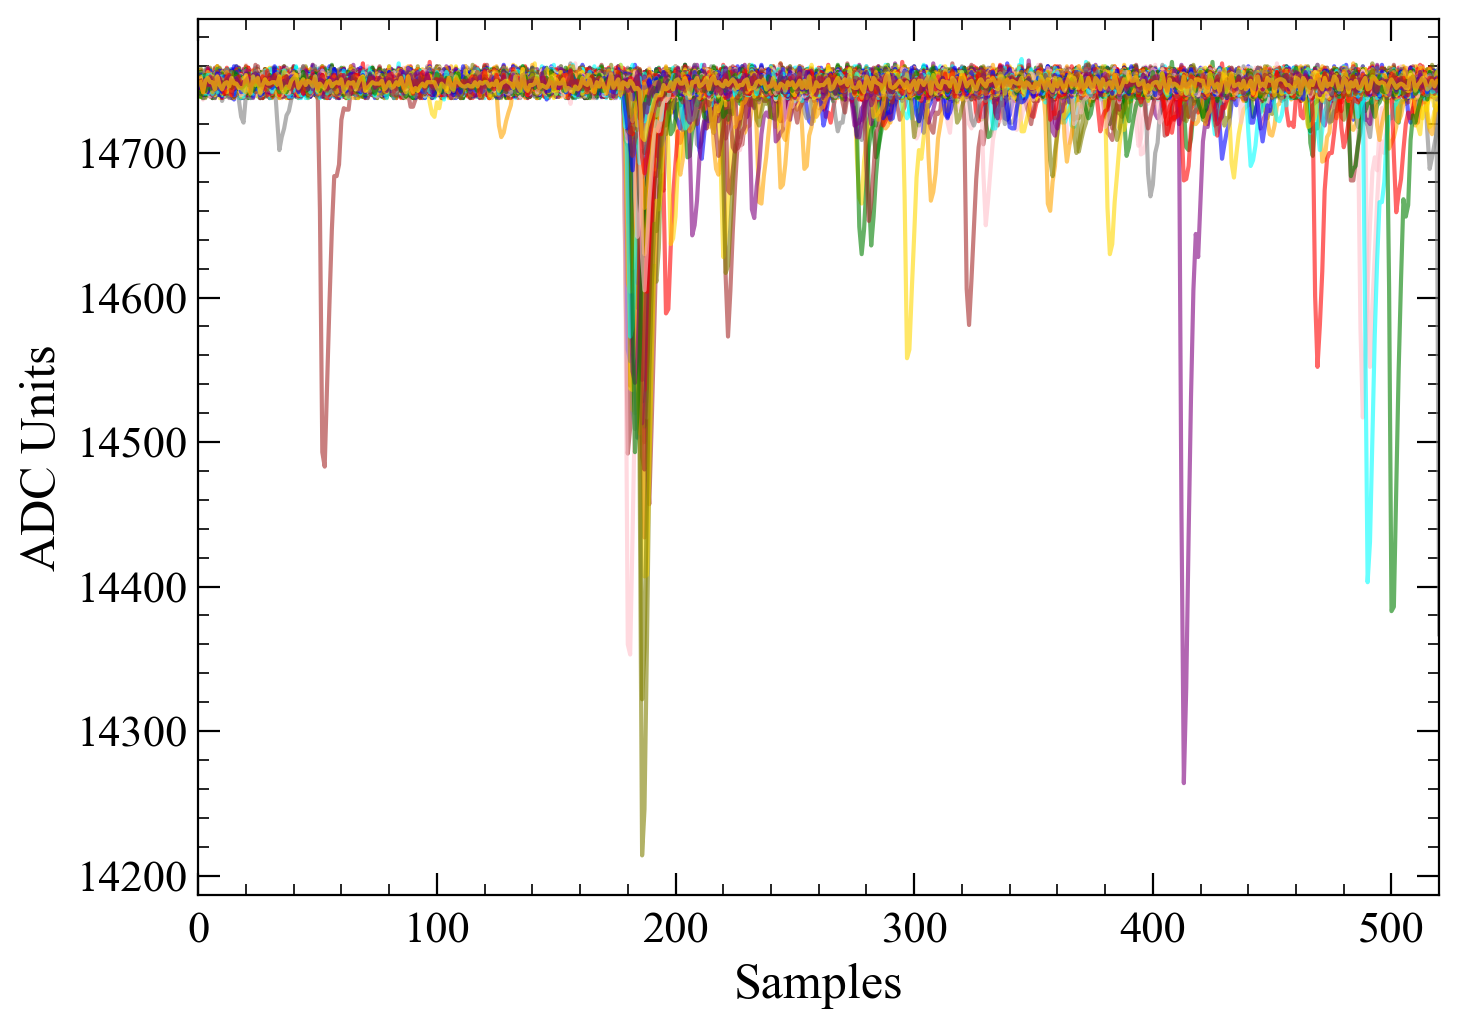

In [18]:
COLORS_LIST = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'gold', 'pink', 'gray', 'olive', 'cyan']

fig, ax = plt.subplots(1,1, dpi=200)

counter = 0
for idx, wf in enumerate(ch0_signals):

    if np.min(wf) > 14725:
        continue

    if counter+1 > len(COLORS_LIST):
        counter = 0

    ax.plot(sampleRange, wf, color=COLORS_LIST[counter], alpha=0.6, lw = 1.5, label=f'Event {idx}')

    counter += 1

ax.set_xlim(0., windowLength)
ax.set_xlabel('Samples')
ax.set_ylabel('ADC Units')
#ax.legend(frameon=False, loc='lower right', fontsize=12)

## Peak Finding and Intgral/Width Calculations

In [19]:
## --------------------- ##
##      USER INPUTS      ##
## --------------------- ##

## show plots
doPlot = False

## parameters for peak finding
height = 15
width = 2
threshold = 1 

## Store values for histograms
Noises, Baselines, Heights, Areas, Lengths = [], [], [], [], []

for idx, wf in enumerate(ch0_signals):

    ## this function kinda sucks
    ## use peakutils function to calculate baseline
    #bLine = peakutils.baseline(np.array(wf),0)

    ## find the baseline using mean of wf before trigger
    baseline = np.mean(wf[:100])

    ## get the noise level
    noise = np.std(wf[:100])

    ## Now use scipy to find the peak
    ## lots of options to set height, width, prominence, threshold
    ## use minimum height and must be 2 samples wide
    ## gotta flip the polarity for this too
    peaks, properties = scipy.signal.find_peaks(-1*np.array(wf-baseline), height=height, width=width, threshold=threshold)

    if len(peaks) == 0:
        continue

    ## store baseline value
    Noises.append(noise)

    ## store baseline value
    Baselines.append(baseline)

    ## Store peak height
    peakHeight = properties['peak_heights'][0]
    Heights.append(peakHeight)

    ## Find width of peak near its base
    rel_height = 99.
    if (peakHeight/noise < 6):
        rel_height=0.85
    if (peakHeight/noise < 3):
        rel_height=0.5

    peakLength = scipy.signal.peak_widths(-1*np.array(wf-baseline), peaks, rel_height=rel_height)

    # Get min/max pulse boundaries 
    pulseMin = np.floor(peakLength[2][0])
    pulseMax = np.ceil(peakLength[3][0])
    region = (sampleRange >= pulseMin) & (sampleRange <= pulseMax)

    ## store widths value
    Lengths.append(peakLength[3][0]-peakLength[2][0])

    ## DO integral of baseline subtracted wf in pulse length range
    area = scipy.integrate.trapz(-1*np.array(wf-baseline)[region])

    ## store areas
    Areas.append(area)

    ## Plot baseline subtracted waveform, peak, and peak widths
    if doPlot:
        fig, ax = plt.subplots(1,1, dpi=200)
        ax.plot(sampleRange, wf-baseline, color='blue', alpha=0.9, lw = 1.5, label=f'Event {idx}')
       
        ax.scatter(peaks[0], -1*properties['peak_heights'][0], marker='x', color='red')

        ax.scatter(peakLength[2][0], 0.,  marker='x', color='green')
        ax.scatter(peakLength[3][0], 0.,  marker='x', color='green')

        ax.set_xlim(0., windowLength)
        ax.set_xlabel('Samples')
        ax.set_ylabel('ADC Units')
        ax.legend(frameon=False, loc='lower right', fontsize=12)

Text(0, 0.5, 'Counts')

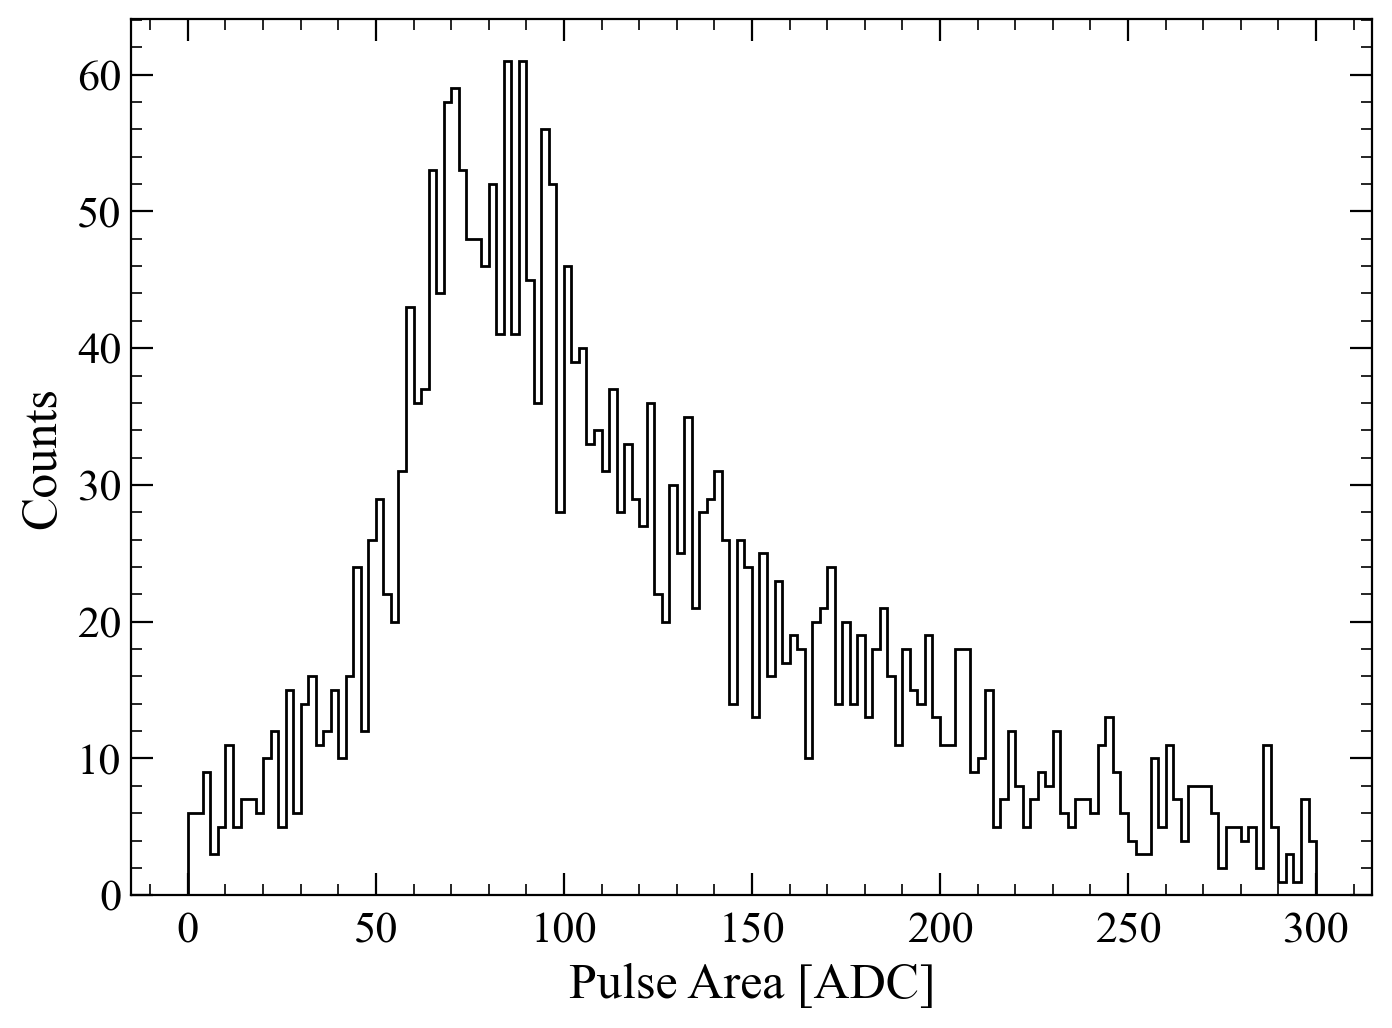

In [21]:
## ------------------------------ ##
##  PLOT THE PULSE AREA SPECTRA   ##
## ------------------------------ ##

fig, ax = plt.subplots(1,1, dpi=200)

ax.hist(Areas, bins=150, range=[0,300], histtype='step', color='black')

ax.set_xlabel('Pulse Area [ADC]')
ax.set_ylabel('Counts')

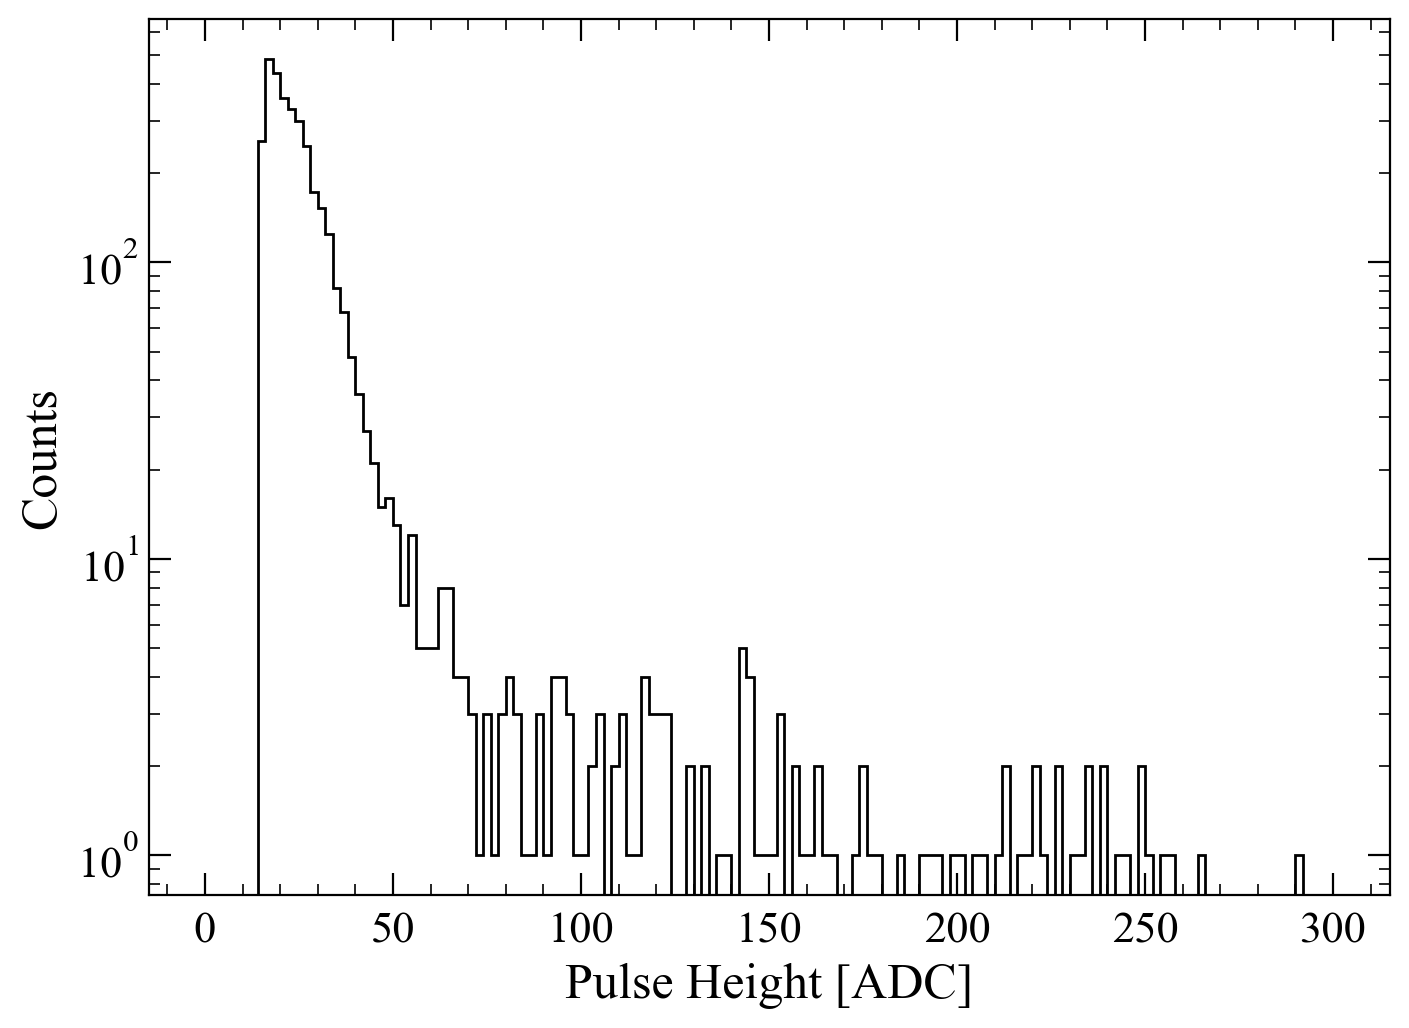

In [23]:
## ------------------------------- ##
##   PLOT THE PEAK HEIGHT SPECTRA  ##
## ------------------------------- ##

fig, ax = plt.subplots(1,1, dpi=200)

ax.hist(Heights, bins=150, range=[0,300], histtype='step', color='black')

ax.set_xlabel('Pulse Height [ADC]')
ax.set_ylabel('Counts')
ax.set_yscale('log')

Text(0, 0.5, 'Counts')

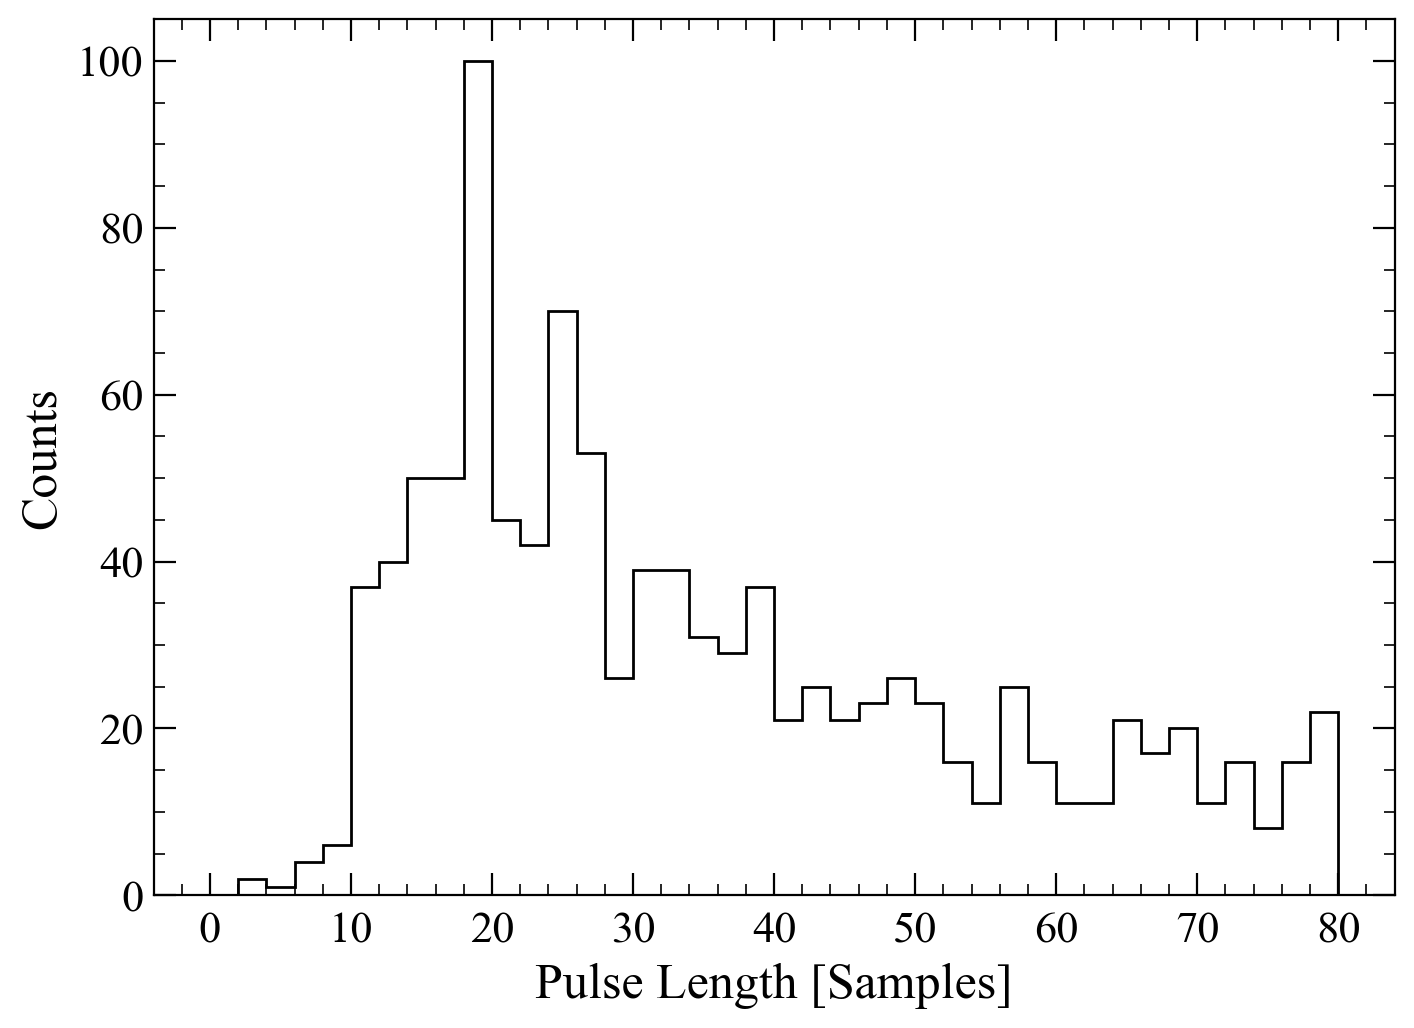

In [26]:
## ------------------------------ ##
##  PLOT THE PULSE LENGTH SPECTRA ##
## ------------------------------ ##

fig, ax = plt.subplots(1,1, dpi=200)

ax.hist(Lengths, bins=40, range=[0,80], histtype='step', color='black')

ax.set_xlabel('Pulse Length [Samples]')
ax.set_ylabel('Counts')